In [2]:
import json
import copy
import pandas as pd
import re
import matplotlib.pyplot as plt
from random import randint
import numpy as np
import os
import seaborn as sns

from IPython.display import Image, SVG, display
from rdkit import Chem
from rdkit.Chem import AllChem,Draw,Descriptors
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage

from lib.Reaction_Library_Mother import *
import lib.Reaction_Library as RL 

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def add_names(x, names_dict):
    try:
        comp_name = names_dict[x.KEGG]
    except:
        comp_name = 'NO_NAME'
    return comp_name

def clean_up_mols(df):
    df_no_SFClBr = df[ ~(df.smiles.str.contains('S')) & ~(df.smiles.str.contains('F')) 
                   & ~(df.smiles.str.contains('Cl')) & ~(df.smiles.str.contains('Br'))
                     & ~(df.smiles.str.contains('I')) & ~(df.smiles.str.contains('Zn'))]
    return df_no_SFClBr


def reverse_reaction(row):
    sub = row.rxn.split('>>')[0]
    prod = row.rxn.split('>>')[1]
    
    new_rxn = prod + '>>' + sub
    
    return new_rxn


def balance_G3(row):
    rxn_ID = row.rxn_ID
    if row.category == 3:
        new_subs = ' + '.join([ rxn_ID.split(' = ')[0], 'C00014'])
        new_prods = ' + '.join([ rxn_ID.split(' = ')[1], 'C00001'])
        rxn_ID = ' = '.join([ new_subs, new_prods ])
    return rxn_ID


def add_BA_IDs(row, df_mols):
    sub_smiles = row.subs_smiles
    prod_smiles = row.prods_smiles
    sub_ID = df_mols[df_mols.smiles == sub_smiles]['BA_ID'].values[0]
    prod_ID = df_mols[df_mols.smiles == prod_smiles]['BA_ID'].values[0]
    return ' = '.join([sub_ID, prod_ID])

# Iterative reduction and oxidation of n-carbon metabolites in the KEGG database. 

## Preparing dataframe of KEGG "seed metabolites"

Load KEGG database of names: 

In [4]:
df_names = pd.read_csv('data/KEGG_names.csv')
names_dict = dict(zip(df_names.KEGG_ID, df_names.name))

Load dataframe with KEGG database:

In [5]:
kegg_file = 'data/KEGG_compounds.csv'
df_kegg = pd.read_csv(kegg_file)

# remove generic compounds 
df_kegg = df_kegg[~df_kegg.smiles.str.contains('\*')]
df_kegg = df_kegg[~df_kegg.smiles.str.contains('\#')]
df_kegg = df_kegg[~df_kegg.smiles.str.contains('\.')]

# remove molecules with non-standard atoms: 
df_kegg = clean_up_mols(df_kegg)
df_kegg.reset_index(inplace=True, drop=True)

# Add names: 
df_kegg['name'] = df_kegg.apply(add_names, 1, args=[names_dict])

# sort by number of carbons
df_kegg.sort_values('n_carbons', inplace=True)

Take a peek at a random KEGG metabolites: 

5,7-Dimethoxyflavone
number of carbons: 17


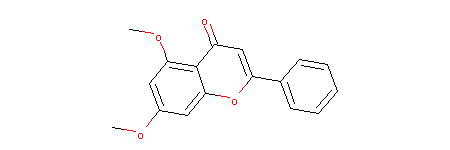

In [6]:
int_temp = randint(0, df_kegg.shape[0])
print(df_kegg.loc[int_temp, 'name'])
print('number of carbons:', df_kegg.loc[int_temp, 'n_carbons'])
AllChem.MolFromSmiles(df_kegg.loc[int_temp, 'smiles'])

Take a peek at random molecules with nC carbon atoms:

Cordycepin: (C08431)


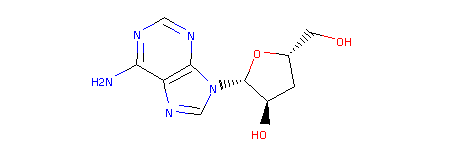

5-Phenyl-1,3-oxazinane-2,4-dione: (C16596)


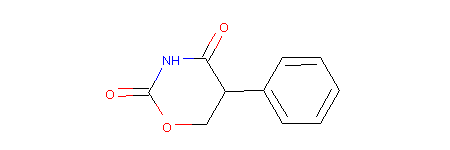

5'-Deoxyadenosine: (C05198)


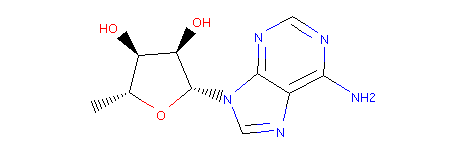

In [7]:
nC = 10
df_nC = df_kegg[df_kegg.n_carbons == nC]

df_sample = df_nC.sample(3)
for index in df_sample.index:
    smi = df_sample.loc[index, 'smiles']
    KEGG_ID = df_sample.loc[index, 'KEGG']
    name = df_sample.loc[index, 'name']
    print(name + ': ('+KEGG_ID+')')
    display(AllChem.MolFromSmiles(smi))

Plot number of compounds as a function of number of carbon atoms to guide the cutoff decision: 

In [8]:
numC_dict = df_kegg.n_carbons.value_counts().to_dict()

plt.bar(numC_dict.keys(), numC_dict.values())
plt.xlim(0, 30)
plt.xlabel('Number Carbons', fontsize = 24)
plt.ylabel('Metabolite Count', fontsize = 24)
plt.xticks(fontsize = 14)
yt = plt.yticks(fontsize = 14)

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

Choose cut-off at certain number of carbons

In [9]:
df_cutoff = df_kegg[df_kegg.n_carbons <= 21]
smiles_cutoff = df_cutoff.canon_smiles.values
df_cutoff.shape

(7174, 15)

## Run the reduction and oxidation functions on the KEGG database

### Iteratively reduce all KEGG seed compounds

In [10]:
# Empty list of all reactions. 
rxn_list = []
Master_Sub_List = [] #master substrate list, where all current + new substrates are stored

# for each KEGG metabolite
for metabolite in smiles_cutoff:
    
    # Run reduction function on a single metabolite
    rxn_list_temp, Master_Sub_List = reduce_metabolite(metabolite, Master_Sub_List)    
    
    # If reactions are generated, store in reaction list
    if len(rxn_list_temp) > 0:
        rxn_list += rxn_list_temp
        rxn_list = list(set(rxn_list)) 
    
    # Update master substrate list
    new_subs_list = [rxn.split('>>')[0] for rxn in rxn_list_temp]
    Master_Sub_List += new_subs_list
    Master_Sub_List = list(set(Master_Sub_List))
    
# store unique set of reactions generated, and sort
rxn_list = list(set(rxn_list))
rxn_list.sort(key = len)

In [11]:
df_reduction = pd.DataFrame()
df_reduction['rxn'] = rxn_list
df_reduction['category'] = df_reduction.apply(RL.categorize_rxn, 1)
df_reduction.shape

(8598, 2)

In [12]:
# write to file:
df_reduction.to_csv('output/21C_reductions.csv', index = False)

Visualize a few generated reactions:

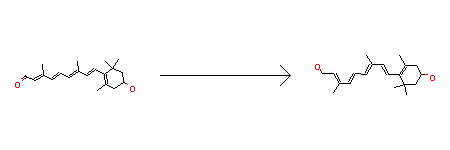

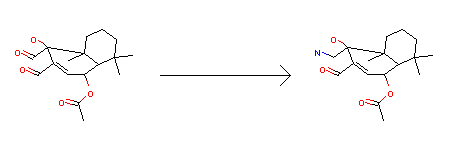

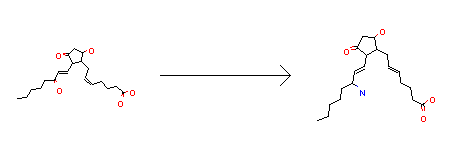

In [13]:
df_rand = df_reduction.sample(3)
for i in df_rand.index:
    smiles_str = df_rand.loc[i, 'rxn']
    display(AllChem.ReactionFromSmarts(str(smiles_str)))

### Iteratively oxidize all KEGG seed compounds

In [14]:
# Empty list of all reactions. 
rxn_list_ox = []
Master_Sub_List = []
# for each KEGG metabolite
for metabolite in smiles_cutoff:
    # Run reduction function on a single metabolite
    rxn_list_temp, Master_Sub_List = oxidize_metabolite(metabolite, Master_Sub_List)
    
    # If there are some reactions, store in reaction list
    if len(rxn_list_temp) > 0:
        rxn_list_ox += rxn_list_temp
        rxn_list_ox = list(set(rxn_list_ox)) 
    
    # Update Master_Sub_List
    new_subs_list = [rxn.split('>>')[0] for rxn in rxn_list_temp]
    Master_Sub_List += new_subs_list
    Master_Sub_List = list(set(Master_Sub_List))


In [15]:
rxn_list_ox = list(set(rxn_list_ox))
rxn_list_ox.sort(key = len)
len(rxn_list_ox)

306412

store in dataframe: 

In [16]:
df_oxidation = pd.DataFrame()
df_oxidation['rxn'] = rxn_list_ox

look at a few random oxidation reactions: 

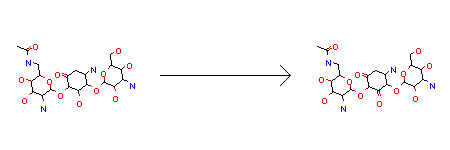

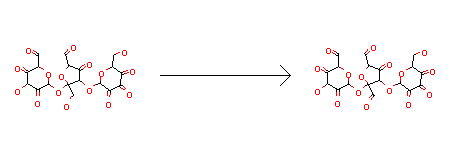

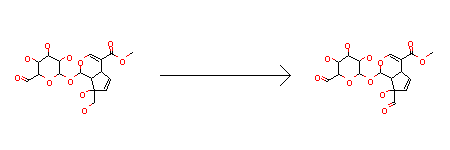

In [17]:
df_rand = df_oxidation.sample(3)
for i in df_rand.index:
    smiles_str = df_rand.loc[i, 'rxn']
    display(AllChem.ReactionFromSmarts(str(smiles_str)))

Write to file: 

In [18]:
df_oxidation['category'] = df_oxidation.apply(RL.categorize_rxn_ox, 1)
df_oxidation.to_csv('output/21C_oxidations.csv', index = False)

NameError: ("name 'G2_function_ox' is not defined", 'occurred at index 0')

## Combine oxidations and the reductions into a single file:

Reverse oxidations to "standardize them" and make them comparable to the reductions:

In [19]:
df_oxidation['rxn'] = df_oxidation.apply(reverse_reaction, 1)

In [20]:
df_oxidation.shape

(306412, 1)

In [ ]:
df_redox = pd.concat([df_reduction, df_oxidation], 0)
df_redox.reset_index(inplace=True, drop=True)

In [86]:
# --> this was the number I used to get: 314998
df_redox.shape

(407400, 2)

Remove duplicated reactions:

In [127]:
# --> this was the number I used to get: 314794
df_redox.drop_duplicates('rxn', inplace=True)
df_redox.shape

(407133, 2)

In [203]:
df_redox.rename(columns={'rxn':'rxn_smiles'}, inplace=True)
# add substrates and products
df_redox['subs_smiles'] = [rxn.split('>>')[0] for rxn in df_redox.rxn_smiles.values]
df_redox['prods_smiles'] = [rxn.split('>>')[1] for rxn in df_redox.rxn_smiles.values]
df_redox.head(2)

,rxn_smiles,category
0,CC=O>>CCO,2
1,CC=O>>CCN,3


Visualize a few random reactions: 

NC1C(=O)C(=O)C(C=O)OC1OC1C(=O)CC(NC(=O)C(O)CC=O)C(O)C1OC1OC(C=O)C(O)C1=O>>NC1CC(NC(=O)C(O)CC=O)C(O)C(OC2OC(C=O)C(O)C2=O)C1OC1OC(C=O)C(=O)C(=O)C1N
3


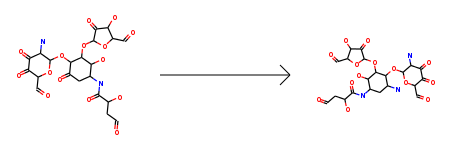

CNC1C(OC2OC(C=O)C(N)C(O)C2=O)OC2C(=O)C(=O)C(OC3C(=O)CC(N)C(O)C3O)OC2C1O>>CNC1C(OC2OC(C=O)C(N)C(O)C2=O)OC2C(=O)C(N)C(OC3C(=O)CC(N)C(O)C3O)OC2C1O
3


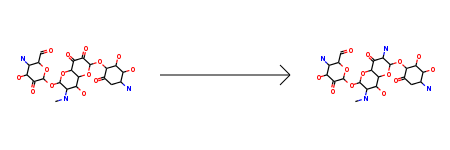

O=C1C(=C(O)C(O)c2cc(O)cc(O)c21)c1c(O)cc(O)c2c1C(=O)C(O)=CC2O>>NC1C(=C(O)C(O)c2cc(O)cc(O)c21)c1c(O)cc(O)c2c1C(=O)C(O)=CC2O
3


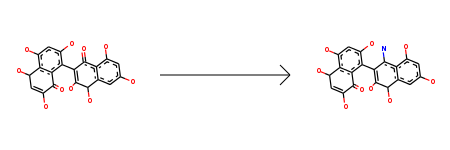

NCC1OC(OC2C(=O)C(OC3OC(C=O)C(=O)C(=O)C3O)C(=O)CC2N)C(=O)C(OP(=O)(O)O)C1O>>NCC1OC(OC2C(=O)C(OC3OC(C=O)C(=O)C(N)C3O)C(=O)CC2N)C(=O)C(OP(=O)(O)O)C1O
3


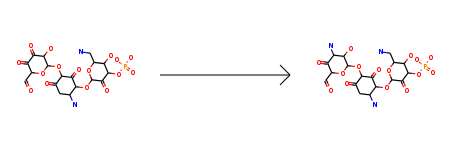

CNC1C(=O)C2OC(OC3C(=O)CC(=O)C(O)C3O)C(=O)C(O)C2OC1OC1OC(CO)C(N)C(=O)C1=O>>CNC1C(=O)C2OC(OC3C(=O)CC(=O)C(O)C3O)C(N)C(O)C2OC1OC1OC(CO)C(N)C(=O)C1=O
3


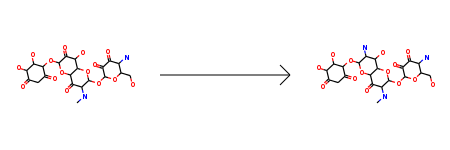

In [213]:
df_rand = df_redox[df_redox.category==3].sample(5)
for i in df_rand.index:
    smiles_str = df_rand.loc[i, 'rxn_smiles']
    category = df_rand.loc[i, 'category']
    print str(smiles_str)
    print category
    display(AllChem.ReactionFromSmarts(str(smiles_str)))

### Get unique molecules and generate compound ID's

Get unique set of molecules: 

In [205]:
subs = [rxn.split('>>')[0] for rxn in df_redox.rxn_smiles.values]
prods = [rxn.split('>>')[1] for rxn in df_redox.rxn_smiles.values]
comps = list(set(subs+prods))
df_mols = pd.DataFrame(columns=['smiles'])
df_mols['smiles'] = comps

# Get number of carbons
df_mols['numC'] = df_mols.apply(RL.count_carbons, 1)
df_mols.sort_values('numC', inplace=True)
df_mols.reset_index(inplace=True, drop=True)

# Add compound IDs ("Z#####")
BA_IDs = ['Z'+str(int(i)).zfill(5) for i in np.arange(df_mols.shape[0])]
df_mols['BA_ID'] = BA_IDs
df_mols = df_mols[['BA_ID', 'numC', 'smiles']]

Add compound IDs information to reaction dataframe:

In [211]:
df_redox['rxn_ID'] = df_redox.apply(add_BA_IDs, 1, args = [df_mols])
df_redox['rxn_ID'] = df_redox.apply(balance_G3, 1)
df_redox = df_redox[['rxn_ID', 'category']]

Write full set of redox reactions to file: 

In [224]:
path_redox_rxns = 'output/21C_redox_rxns.csv'
path_mols = 'output/21C_mols.csv'
df_redox.to_csv(path_redox_rxns, index=False)
df_mols.to_csv(path_mols, index=False)